# Introduction

Animal shelters work hard to ensure that animals are adopted into loving homes, but not all animals are adopted at the same rate. This project aims to predict whether an animal (dog, cat, etc.) will be adopted, based on its characteristics such as age, breed, color, and health status. 
This is a binary classification problem (adopted or not adopted). 

Data information including breed, color, sex, and age is provided from the Austin Animal Center.

The prediction result of this dataset can help people understand trends in animal adoption outcomes. These insights could help shelters focus their energy on specific animals who need a little extra help finding a new home. 

# Import Modules

In [49]:
# Import the necessary packages
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz
/kaggle/input/shelter-animal-outcomes/train.csv.gz
/kaggle/input/shelter-animal-outcomes/test.csv.gz


In [50]:
train_df = pd.read_csv('/kaggle/input/shelter-animal-outcomes/train.csv.gz')

print("Training Dataset shape:", train_df.shape)
print('\n')
print(train_df.info())


Training Dataset shape: (26729, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB
None


# Exploratory Data Analysis (EDA)

The dataset contains key features such as AnimalType, AgeInDays, Breed, Color, and OutcomeType. The target variable OutcomeType revealed an imbalance, with adoption outcomes being more frequent than other outcomes like transfer or euthanasia.

Data showed that most animals were young, with the age distribution heavily skewed toward the lower end. We found that younger animals and dogs were more likely to be adopted compared to older ones or cats. Correlation analysis revealed some expected relationships, such as a  correlation between age, sex and adoption likelihood.

In [51]:
# Checking the animal outcome distribution

print(train_df["OutcomeType"].value_counts())
print('\n')

# Dropping animal that died since died animal cannot be adopted, therefore irrelavant in the prediction.

train_df = train_df[train_df["OutcomeType"] != "Died"]
print("Total Not Adopted:",(train_df["OutcomeType"]!="Adoption").sum())
print('\n')
train_df.head()

OutcomeType
Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: count, dtype: int64


Total Not Adopted: 15763




,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


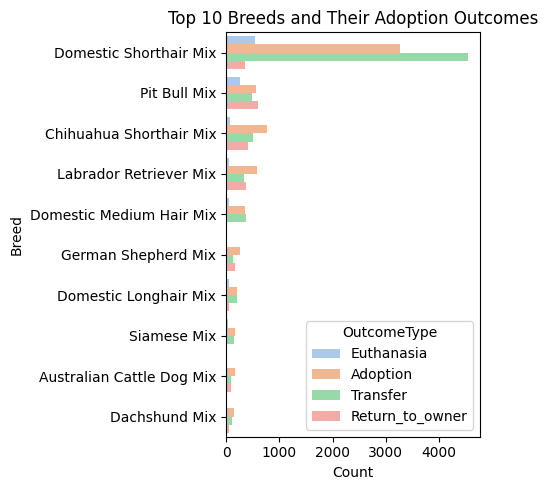

In [52]:
# Top 10 most abundant breed in the shelter and their outcome type

top_breeds = train_df['Breed'].value_counts().head(10).index
breed_df = train_df[train_df['Breed'].isin(top_breeds)]

plt.figure(figsize=(5, 5))
sns.countplot(y='Breed', hue='OutcomeType', data=breed_df, order=top_breeds, palette='pastel')
plt.title("Top 10 Breeds and Their Adoption Outcomes")
plt.xlabel("Count")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()

From the observation, cats and dogs get about equal adoption outcome. Domestic shorthair mix (cat) is the most seen type of animal.

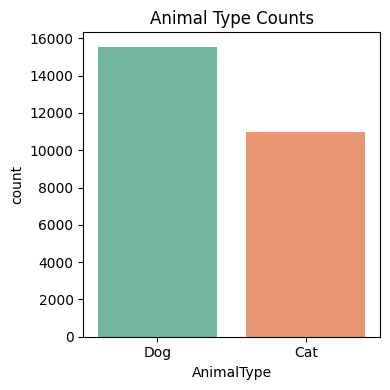

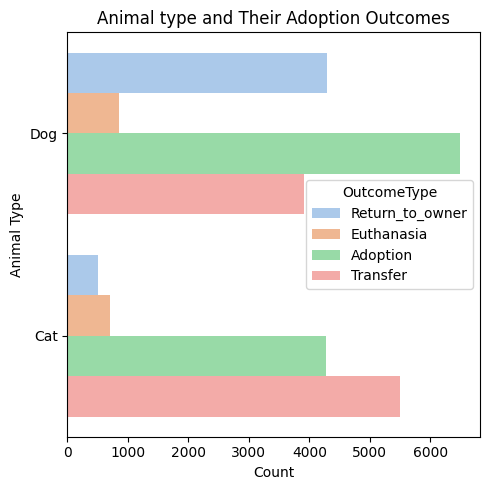

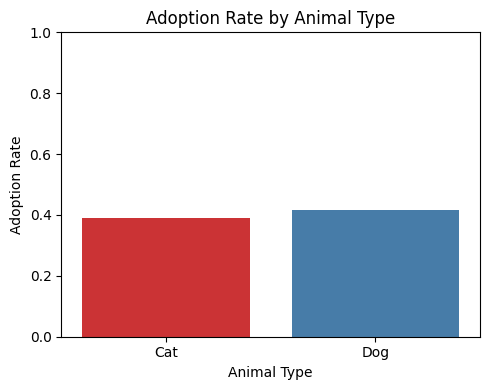

In [53]:
# Animal Type
plt.figure(figsize=(4, 4))
sns.countplot(x='AnimalType', data=train_df, palette='Set2')
plt.title("Animal Type Counts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
sns.countplot(y='AnimalType', hue='OutcomeType', data=train_df, palette='pastel')
plt.title("Animal type and Their Adoption Outcomes")
plt.xlabel("Count")
plt.ylabel("Animal Type")
plt.tight_layout()
plt.show()

# Calculate adoption rate per AnimalType
adoption_rate = (
    train_df[train_df['OutcomeType'] == 'Adoption']
    .groupby('AnimalType')
    .size() / train_df.groupby('AnimalType').size()
).reset_index(name='AdoptionRate')

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x='AnimalType', y='AdoptionRate', data=adoption_rate, palette='Set1')
plt.title('Adoption Rate by Animal Type')
plt.ylabel('Adoption Rate')
plt.xlabel('Animal Type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [54]:
# Converting AgeuponOutcome into number of days for training purpose
def convert_age_to_days(age_str):
    if pd.isnull(age_str):
        return np.nan
    age_str = age_str.lower()
    num, unit = age_str.split()[:2]
    num = int(num)
    if 'day' in unit:
        return num
    elif 'week' in unit:
        return num * 7
    elif 'month' in unit:
        return num * 30
    elif 'year' in unit:
        return num * 365
    else:
        return np.nan

train_df["age_in_days"] = train_df["AgeuponOutcome"].apply(convert_age_to_days)

I converted the Age upon Outcome column into days, and grouped animals into four age ranges: ~6 months, 2 years, 7 years, and 13+ years.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


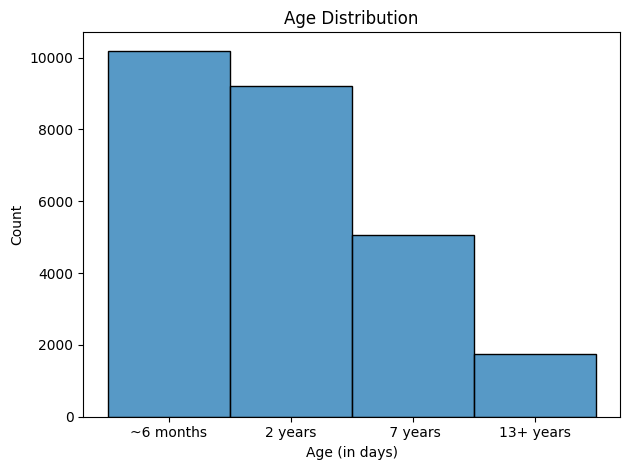

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


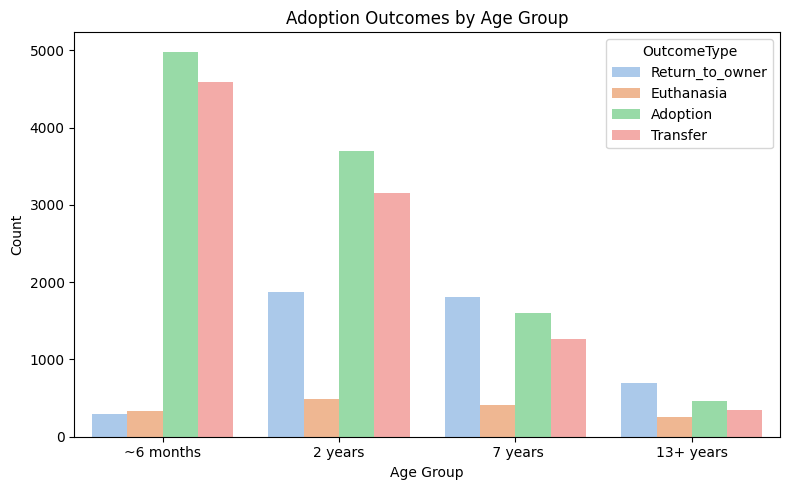

/tmp/ipykernel_35/1338459363.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_age_group = train_df.groupby('AgeGroup').size()
/tmp/ipykernel_35/1338459363.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adopted_per_age_group = train_df[train_df['OutcomeType'] == 'Adoption'].groupby('AgeGroup').size()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

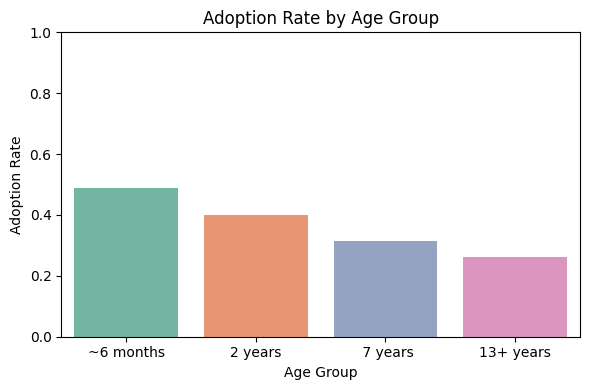

In [55]:
bins = [0, 180, 730, 2555, 5000]  # ~6 months, 2 years, 7 years, 13+ years
labels = ['~6 months', '2 years', ' 7 years', '13+ years']
train_df['AgeGroup'] = pd.cut(train_df['age_in_days'], bins=bins, labels=labels)

# Age Distribution
sns.histplot(train_df['AgeGroup'], bins=30)
plt.title("Age Distribution")
plt.xlabel("Age (in days)")
plt.tight_layout()
plt.show()

# Age related to adoption outcome
plt.figure(figsize=(8, 5))
sns.countplot(x='AgeGroup', hue='OutcomeType', data=train_df, palette='pastel')
plt.title("Adoption Outcomes by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot for Age vs adoption rate
total_per_age_group = train_df.groupby('AgeGroup').size()
adopted_per_age_group = train_df[train_df['OutcomeType'] == 'Adoption'].groupby('AgeGroup').size()

# Compute adoption rate
adoption_rate_by_age = (adopted_per_age_group / total_per_age_group).reset_index(name='AdoptionRate')

plt.figure(figsize=(6, 4))
sns.barplot(x='AgeGroup', y='AdoptionRate', data=adoption_rate_by_age, palette='Set2')
plt.title("Adoption Rate by Age Group")
plt.ylabel("Adoption Rate")
plt.xlabel("Age Group")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

From the observation, you can see younger animals are easier to get adopted.

# Data Cleaning

In [56]:
# Converting OutcomeType string into binary 1 = adopted, and 0 = not adopted for binary classification.

train_df["adopted"] = (train_df["OutcomeType"] == "Adoption").astype(int)
train_df = train_df.dropna(subset=["AnimalType", "AgeuponOutcome", "Breed", "Color"])

# Encode categorical features
categorical_features = ["AnimalType", "SexuponOutcome", "Breed", "Color"]
label_encoders = {}
for col in categorical_features:
    label = LabelEncoder()
    train_df[col] = label.fit_transform(train_df[col])
    label_encoders[col] = label


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

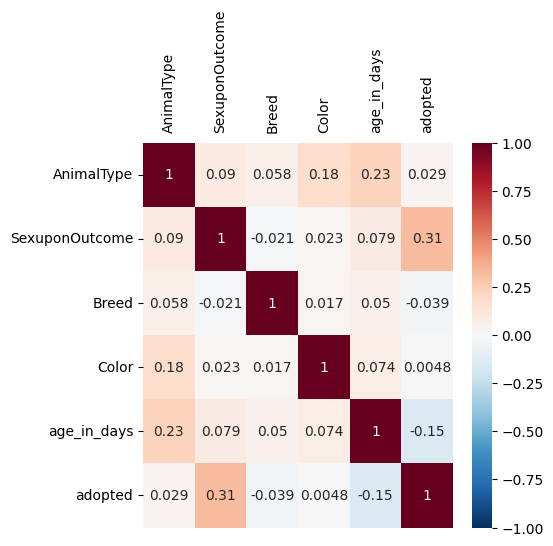

In [57]:
# Drop AnimalID, Name, DateTime, OutcomeSubtype since they are less likely to be the feature associate with adoption. 
# OutcomeType is drop because it has been converted to binary string in "adopted" column, AgeuponOutcome also been drop because there's a column tranform it to days.

try:
    train_df = train_df.drop(['AnimalID', 'Name', 'DateTime','OutcomeType', 'OutcomeSubtype','AgeuponOutcome','AgeGroup'], axis=1)
except KeyError as e:
    print(f"Columns already dropped: {e}")


df_corr = train_df.corr()

fig, ax = plt.subplots(figsize=(5,5)) 
ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('none')
sns.heatmap(df_corr, vmin=-1, vmax=1, cmap="RdBu_r", center= 0, annot=True, ax=ax)


From the correlation chart, you can see the adoption is most strongly related to animal sex, and age.

# Modeling and Evaluation

I tried to train the data with the following models:

- Random forest classification
- Adaboost classification

This way I can compare the difference on performance of these two different methods and determine which one works better

# Random Forest
Firstly, I'm going to be using random forest with train_test_split on 0.2 on the training dataset. 

In [58]:
# Train Test Split
features = ["AnimalType", "SexuponOutcome", "Breed", "Color", "age_in_days"]
X = train_df[features]
y = train_df["adopted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training using random forest method 
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [68]:
# Result evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Testing Accuracy:", model.score(X_test, y_test))
print("Training Accuracy:", model.score(X_train, y_train))
print('\n')

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test,y_prob))

Testing Accuracy: 0.7405242315670375
Training Accuracy: 0.9123096506529631


              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3126
           1       0.69      0.67      0.68      2177

    accuracy                           0.74      5303
   macro avg       0.73      0.73      0.73      5303
weighted avg       0.74      0.74      0.74      5303

ROC AUC Score: 0.8304256005097203


# Hyperparameter tuning

To optimize the performance of the Random Forest classifier, GridSearchCV is used for hyperparameter tuning. A parameter grid that included various values for max_depth, n_estimators, and min_samples_leaf to explore different tree depths, numbers of estimators, and minimum samples per leaf node is used.

In [60]:
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'n_estimators': [100, 200],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}


In [61]:
# Evaluate results on best performing model 

best_model = grid.best_estimator_

grid_y_pred = best_model.predict(X_test)
print("Testing Accuracy:", best_model.score(X_test, y_test))
print("Training Accuracy:", best_model.score(X_train, y_train))
print('\n')

print(classification_report(y_test, grid_y_pred))

Testing Accuracy: 0.766170092400528
Training Accuracy: 0.7766724812597238


              precision    recall  f1-score   support

           0       0.78      0.85      0.81      3126
           1       0.75      0.65      0.69      2177

    accuracy                           0.77      5303
   macro avg       0.76      0.75      0.75      5303
weighted avg       0.76      0.77      0.76      5303



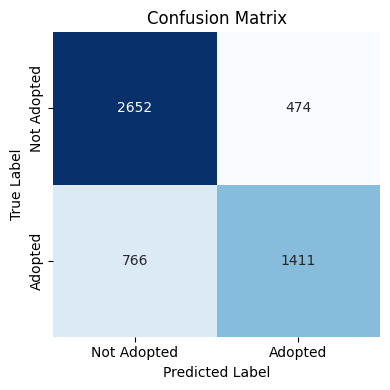

In [62]:
cm = confusion_matrix(y_test, grid_y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Adopted', 'Adopted'],
            yticklabels=['Not Adopted', 'Adopted'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

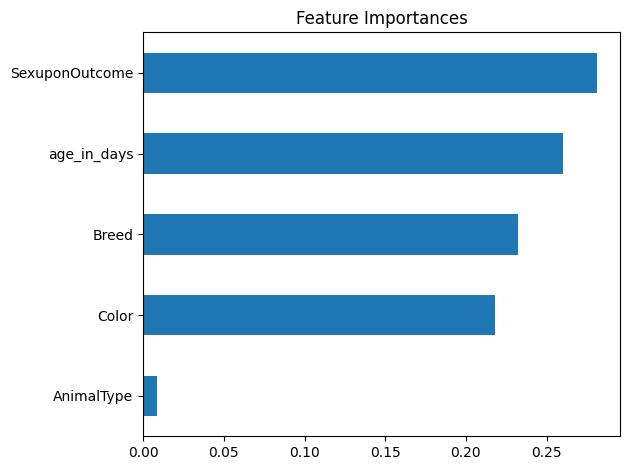

In [63]:
# Feature Importance
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='Feature Importances')
plt.tight_layout()
plt.show()

ROC AUC Score: 0.8607746577594939


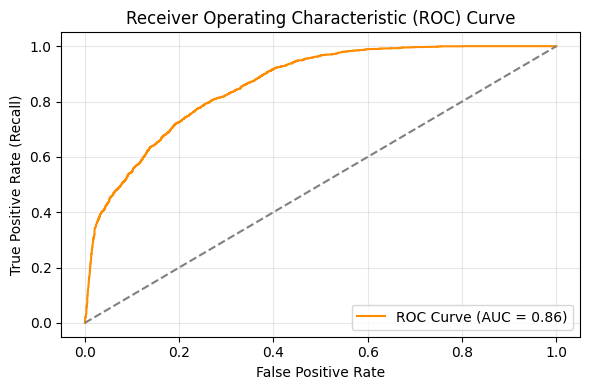

In [64]:
# Plotting ROC curve
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random guessing)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The AUC score came out to be 0.86, which indicates that the model does a good job distinguishing between adopted and non-adopted animals. (0.5 would be random guessing)

# Adaboost

In [69]:
# Trying Adaboost model for potential improvement in the accuracy

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost model
ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

# Train model
ada_model.fit(X_train, y_train)

# Predict
ada_y_pred = ada_model.predict(X_test)
ada_y_prob = ada_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Training Accuracy:", ada_model.score(X_train, y_train))
print("Test Accuracy:", ada_model.score(X_test, y_test))
print('\n')
print(classification_report(y_test, ada_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, ada_y_prob))


Training Accuracy: 0.7639432369996699
Test Accuracy: 0.7640957948331133


              precision    recall  f1-score   support

           0       0.77      0.85      0.81      3126
           1       0.75      0.65      0.69      2177

    accuracy                           0.76      5303
   macro avg       0.76      0.75      0.75      5303
weighted avg       0.76      0.76      0.76      5303

ROC AUC Score: 0.8572921525010941


# Hyperparameter tuning

To optimize the performance of the adaboost classifier, GridSearchCV is used for hyperparameter tuning. A parameter grid that included various values for learning_rate, n_estimators, and estimator__max_depth is used.

In [70]:
# Define a new base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Parameter grid for adaboost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5],
    'estimator__max_depth': [1, 2, 3]
}

# Initialize AdaBoost with base estimator
ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Perform grid search
grid_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train, y_train)

# Print results
print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best cross-validation accuracy:", grid_ada.best_score_)

# Evaluate on test set
best_ada = grid_ada.best_estimator_
test_accuracy = best_ada.score(X_test, y_test)
print("Test accuracy with best AdaBoost model:", test_accuracy)

Best parameters for AdaBoost: {'estimator__max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 50}
Best cross-validation accuracy: 0.7623401241171219
Test accuracy with best AdaBoost model: 0.7656043748821422


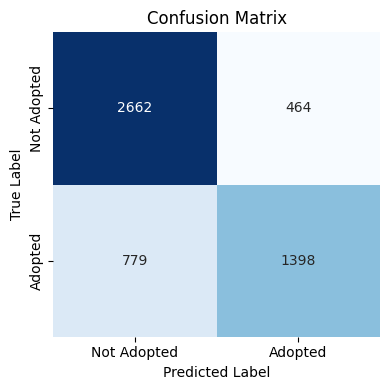

In [72]:
ada_grid_y_pred = best_ada.predict(X_test)

cm_ada = confusion_matrix(y_test, ada_grid_y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Adopted', 'Adopted'],
            yticklabels=['Not Adopted', 'Adopted'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

ROC AUC Score: 0.8607746577594939


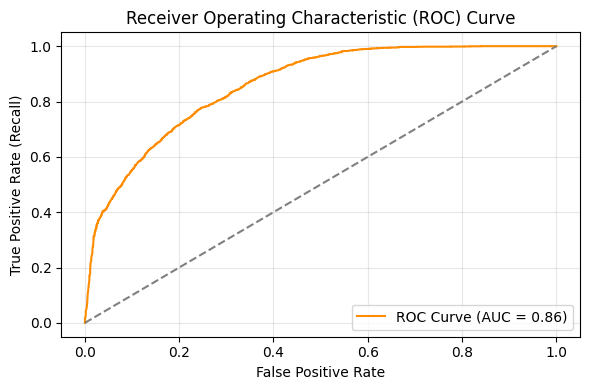

In [73]:
# Plotting ROC curve
ada_y_proba = best_ada.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, ada_y_proba)
ada_auc_score = roc_auc_score(y_test, ada_y_proba)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {ada_auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random guessing)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#  Conclusion

The Random Forest model demonstrated strong predictive performance after hyperparameter tuning, effectively utilizing features such as animal type, age, breed, and intake condition. To explore further improvements, I also applied the AdaBoost algorithm. After performing GridSearch for both models, the AdaBoost classifier achieved the same testing accuracy as the Random Forest, suggesting it is a competitive alternative for this classification task.

Future work may involve testing other ensemble methods like Gradient Boosting or XGBoost, as well as addressing class imbalance issues using techniques like SMOTE. This analysis provides valuable insights that can help animal shelters better understand the factors influencing adoption outcomes and assist in prioritizing care and outreach for animals less likely to be adopted quickly.

# Github

Notebook is available on github: https://github.com/nehcynnaf/Shelter-Animal-Outcomes/blob/main/predicting-animal-adoption-success-at-shelters.ipynb